In [4]:
pip install keras_metrics

In [27]:
import keras
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras_metrics as km
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
data_dir ="/content/gdrive/My Drive/video_data"
img_height , img_width = 64, 64
seq_len = 16

In [10]:
classes = [ 'mouth','sit down','climb','fall','walk','spoon','grab']

In [11]:
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [12]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [52]:
def schedular(epochs):
  if epochs < 10:
    return 0.001

  else:
    return 0.001 * math.exp(0.1*(10-epochs))

  learning_rate_schedular= tf.keras.callbacks.LearningRateScheduler(schedular)

In [53]:
X, Y = create_data(data_dir)
 
X_train, X_test, y_train, y_test = train_test_split(X/255, Y, test_size=0.20, shuffle=True, random_state=0)
 

climb
walk
Defected frame
Defected frame
grab
Defected frame
sit down
mouth
spoon
fall


In [54]:
np.save('/content/gdrive/My Drive/data/save_X',X_train)


In [55]:
np.save('/content/gdrive/My Drive/data/save_Y',y_train)

In [56]:
np.save('/content/gdrive/My Drive/data/save_X_test',X_test)

In [57]:
np.save('/content/gdrive/My Drive/data/save_Y_test',y_test)

In [21]:


X_train=np.load('/content/gdrive/My Drive/data/save_X.npy')
y_train=np.load('/content/gdrive/My Drive/data/save_Y.npy')
X_test=np.load('/content/gdrive/My Drive/data/save_X_test.npy')
y_test=np.load('/content/gdrive/My Drive/data/save_Y_test.npy')


In [22]:
 

model = Sequential()
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), strides = (2,2), return_sequences = True, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))

model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), strides = (2,2), return_sequences =  True, data_format = "channels_last"))
model.add(Dropout(0.3))

model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), strides = (2,2), return_sequences =  True, data_format = "channels_last"))
model.add(Dropout(0.3))


model.add(ConvLSTM2D(filters = 128, kernel_size = (3, 3), strides = (2,2), return_sequences = False, data_format = "channels_last"))





model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(7, activation = "softmax"))


 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 16, 31, 31, 32)    40448     
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 16, 15, 15, 32)    73856     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 15, 15, 32)    0         
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 16, 7, 7, 64)      221440    
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 7, 7, 64)      0         
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 3, 3, 128)         885248    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [23]:

opt = tensorflow.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]
 
history = model.fit(x = X_train, y = y_train, epochs=20, batch_size = 32, shuffle=True, validation_split=0.4, callbacks=callbacks) #validation split 조절

y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
19/19 [==============================] - 228s 12s/step - loss: 1.9139 - accuracy: 0.2353 - val_loss: 1.8604 - val_accuracy: 0.2217
Epoch 2/20
19/19 [==============================] - 216s 11s/step - loss: 1.8332 - accuracy: 0.2437 - val_loss: 1.8684 - val_accuracy: 0.2217
Epoch 3/20
19/19 [==============================] - 211s 11s/step - loss: 1.8339 - accuracy: 0.2857 - val_loss: 1.8276 - val_accuracy: 0.2393
Epoch 4/20
19/19 [==============================] - 215s 11s/step - loss: 1.7690 - accuracy: 0.3008 - val_loss: 1.7065 - val_accuracy: 0.3375
Epoch 5/20
19/19 [==============================] - 209s 11s/step - loss: 1.6947 - accuracy: 0.3513 - val_loss: 1.6529 - val_accuracy: 0.3703
Epoch 6/20
19/19 [==============================] - 211s 11s/step - loss: 1.5796 - accuracy: 0.4185 - val_loss: 1.6690 - val_accuracy: 0.3401
Epoch 7/20
19/19 [==============================] - 215s 11s/step - loss: 1.4984 - accuracy: 0.4420 - val_loss: 1.5102 - val_accuracy: 0.4559
Epoch 

In [28]:
checkpoint_path = "/content/gdrive/My Drive/data/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# 새로운 콜백으로 모델 훈련하기
###model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

#model.fit(x = X_train, y = y_train, epochs=10, batch_size = 32, shuffle=True, validation_split=0.2, callbacks=callbacks) #validation split 조절

     # 콜백을 훈련에 전달합니다

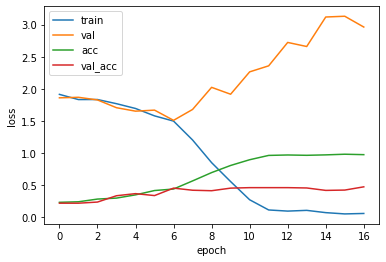

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val','acc','val_acc'])
plt.show()